In [1]:
%load_ext autoreload
%autoreload

In [2]:
import pathlib
if pathlib.Path().resolve().name == 'notebooks':
    %cd ..
%pwd

c:\Users\Lenovo\Desktop\final_version\NHL


'c:\\Users\\Lenovo\\Desktop\\final_version\\NHL'

In [3]:
import numpy as np 
from dotenv import load_dotenv
from sklearn import preprocessing
import seaborn as sn
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pickle as pkl
from xgboost import plot_importance
from sklearn.metrics import classification_report
import pickle
import warnings
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.calibration import calibration_curve
warnings.filterwarnings("ignore")
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from copy import deepcopy
from itertools import product
from collections import defaultdict
import shap

In [4]:
# Load the pkl file
with open('final.pkl', 'rb') as file:
    data = pickle.load(file)

# Convert to DataFrame
df = pd.DataFrame(data)

In [5]:
df.head()

,Game_id,Game_time,Period,Time,Team,OppTeam,Goal,X,Y,Shooter,...,Opp_players,X_net,Shot_distance,Shot_angle,Rebound_angle,Year,Shooter_ratio,Goalie_ratio,Team_goals,Opp_concedes
0,1,71,1,01:11,TOR,OTT,False,-77.0,5.0,Mitchell Marner,...,5,12.0,13.000000,22.619865,0.0,2016,0.1,0.9,3.0,3.0
1,1,173,1,02:53,OTT,TOR,False,86.0,13.0,Chris Kelly,...,5,3.0,13.341664,77.005383,0.0,2016,0.1,0.9,3.0,3.0
2,1,241,1,04:01,OTT,TOR,False,23.0,-38.0,Cody Ceci,...,5,66.0,76.157731,29.931512,0.0,2016,0.1,0.9,3.0,3.0
3,1,286,1,04:46,OTT,TOR,False,33.0,-15.0,Erik Karlsson,...,5,56.0,57.974132,14.995079,0.0,2016,0.1,0.9,3.0,3.0
4,1,406,1,06:46,TOR,OTT,False,-34.0,28.0,Martin Marincin,...,5,55.0,61.717096,26.980231,0.0,2016,0.1,0.9,3.0,3.0


In [6]:
df.columns

Index(['Game_id', 'Game_time', 'Period', 'Time', 'Team', 'OppTeam', 'Goal',
       'X', 'Y', 'Shooter', 'Goalie', 'Type', 'Empty_net',
       'Previous_event_type', 'Previous_x', 'Previous_y',
       'Previous_time_since', 'Previous_distance', 'Speed', 'Is_rebound',
       'Time_since_powp', 'Players', 'Opp_players', 'X_net', 'Shot_distance',
       'Shot_angle', 'Rebound_angle', 'Year', 'Shooter_ratio', 'Goalie_ratio',
       'Team_goals', 'Opp_concedes'],
      dtype='object')

In [7]:
le = LabelEncoder()
categorical_columns = ['Team', 'OppTeam', 'Shooter', 'Goalie', 'Type','Previous_event_type']
# Apply label encoding to each categorical column
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

In [8]:
label_encoder = LabelEncoder()
df['Is_rebound'] = label_encoder.fit_transform(df['Is_rebound'])
label_encoder = LabelEncoder()
df['Empty_net'] = label_encoder.fit_transform(df['Empty_net'])
label_encoder = LabelEncoder()
df['Goal'] = label_encoder.fit_transform(df['Goal'])

In [9]:
L=["Time","Period","X","Y","Previous_x","Previous_y","X_net"]
df=df.drop(L,axis=1)

In [10]:
df['Shot_angle'] = df['Shot_angle'].abs()

In [11]:
X_train, x_valid, y_train, y_valid = train_test_split(df.drop(['Goal'],inplace=False,axis=1), df['Goal'], test_size=0.2, random_state=42)

### QUESTION2

In [12]:
X_train1XG_All = X_train.to_numpy().reshape(-1, len(X_train.columns))
X_val1XG_All = x_valid.to_numpy().reshape(-1, len(X_train.columns))

xgb_clf = XGBClassifier().fit(X_train1XG_All, y_train)


In [13]:
preds_Val = xgb_clf.predict(X_val1XG_All)
print("ROC AUC : ", roc_auc_score(y_valid, preds_Val))

ROC AUC :  0.5331442632226324


In [14]:
acc=accuracy_score(y_valid, preds_Val)
print(f'Validation accuracy: ', acc)

Validation accuracy:  0.9095642221043522


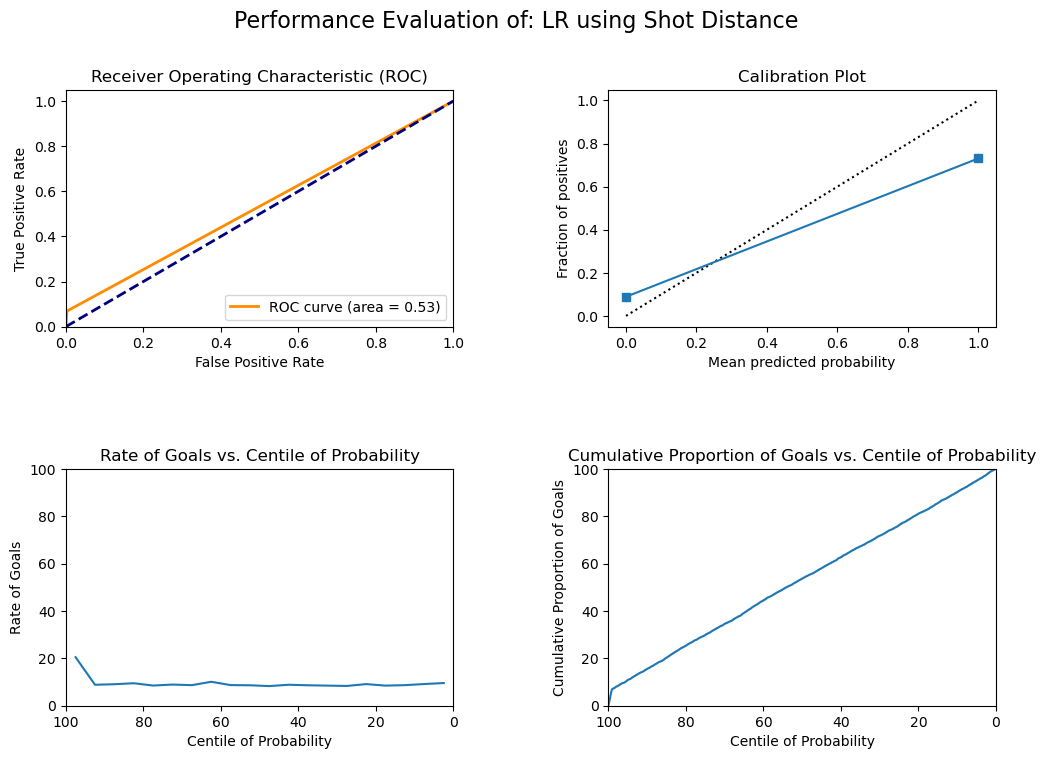

In [15]:
from src.visualizations import plots
plots(y_valid,preds_Val,"LR using Shot Distance")

In [16]:
# import xgboost.sklearn as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import TimeSeriesSplit

# cv = 2

# trainX= [[1], [2], [3], [4], [5]]
# trainY = [1, 2, 3, 4, 5]

# # these are the evaluation sets
# testX = trainX 
# testY = trainY

# param_grid = {
#     'n_estimators': [1000, 2000, 3000],
#     'max_depth': [5, 8, 11],
#     'learning_rate':[0.01,0.05,0.1],
#     'scale_pos_weight':[1,9],
# }
# fit_params={"early_stopping_rounds":42, 
#             "eval_metric" : "mae", 
#             "eval_set" : [[testX, testY]]}

# model = xgb.XGBRegressor()

# gridsearch = GridSearchCV(model, paramGrid, verbose=1,             
#          cv=TimeSeriesSplit(n_splits=cv).get_n_splits([trainX, trainY]))

# gridsearch.fit(trainX, trainY, **fit_params)

In [18]:
def GridSearchCV_XGB_early_stoppping(param_grid, fit_params, scorer, cv, X, y, X_val, y_val,n_estimators):
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()
        
    param_names, param_values = zip(*list(param_grid.items()))

    cv_best_iterations = defaultdict(list)
    cv_results = defaultdict(list)

    # for train_index, test_index in cv.split(X, y):
    #     X_in, X_out = X[train_index], X[test_index]
    #     y_in, y_out = y[train_index], y[test_index]

    fit_params_cv = deepcopy(fit_params)
    fit_params_cv['eval_set'] = [(X_val.to_numpy(), y_val.to_numpy())]

    #fit_params_cv['eval_set'] = [(X_out, y_out)]
        #fit_params_cv['eval_set'] = [(X_val.to_numpy(), y_val.to_numpy())]

    for value_combination in product(*param_values):
            param_grid_cv = tuple(zip(param_names, value_combination))
            print(param_grid_cv)
            xgboost = XGBClassifier(n_estimators=n_estimators,**dict(param_grid_cv))

            xgboost.fit(X, y, **fit_params_cv)
            best_iteration = xgboost.get_num_boosting_rounds() if 'early_stopping_rounds' not in fit_params_cv else xgboost.best_iteration
            cv_best_iterations[param_grid_cv].append(best_iteration)

            score = scorer(xgboost, X_val, y_val)
            cv_results[param_grid_cv].append(score)
        
    best_params_xgb, score_list = max(cv_results.items(), key=lambda x: np.array(x[1]).mean())

    # Note that our XGBoost model may stop early,
    # so we calculate the mean of the actual number of estimators in each fold,
    # in place of the originally planned n_estimators after finishing cross validation.
    #n_estimators = int(round(np.array(cv_best_iterations[best_params_xgb]).mean()))
    
    best_params_xgb = dict(best_params_xgb)
    #best_params_xgb['n_estimators'] = n_estimators

    print ("Best score: {:.3f}".format(np.array(score_list).mean()))
    print ("Best Parameters: {}".format(best_params_xgb))
    return best_params_xgb

In [19]:
from copy import deepcopy
from itertools import product
from collections import defaultdict

In [20]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Créer un modèle XGBoost
xgb_model = xgb.XGBClassifier()
n_estimators = 2000 
# Définir la grille des hyperparamètres à rechercher
param_grid = {
   
    'max_depth': [5, 8, 11],
    'learning_rate':[0.01,0.05,0.1],
    'scale_pos_weight':[1,9],
}
fit_params = {
    'eval_metric': "auc",
    'early_stopping_rounds': 3,
    'verbose': 200
}
scorer = make_scorer(accuracy_score, greater_is_better=False)

# Effectuer une recherche par grille avec validation croisée
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=kfold ,verbose=4)
#grid_search.fit(X_train, y_train,early_stopping_rounds=10)

# Obtenir les meilleurs paramètres
#best_params = grid_search.best_params_
best_params_xgb = GridSearchCV_XGB_early_stoppping(param_grid, fit_params, scorer, kfold, X_train, y_train,x_valid,y_valid,n_estimators)
# # Entraîner le modèle avec les meilleurs paramètres sur l'ensemble d'entraînement complet
# best_xgb_model = xgb.XGBClassifier(**best_params_xgb)
# grid_result=best_xgb_model.fit(X_train, y_train)


# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#  # Prédictions sur l'ensemble de test
# y_pred = best_xgb_model.predict(x_valid)

### QUESTION3

In [21]:
xgb_allfeatures = XGBClassifier(n_estimators=1570,max_depth=5,learning_rate=0.01,scale_pos_weight=9).fit(X_train, y_train)

In [22]:
# bst.save_model('model/test.model.json')
preds = xgb_allfeatures.predict(x_valid)
probs = xgb_allfeatures.predict_proba(x_valid)[:,1]
# Calculer et afficher le score ROC AUC
score_roc_auc = roc_auc_score(y_valid, probs)
print("ROC AUC : ", score_roc_auc)
precision = precision_score(y_valid, preds)
print("precision : ", precision)

recall = recall_score(y_valid, preds)
print("recall : ", recall)

ROC AUC :  0.7834359015539523
precision :  0.19778173895820955
recall :  0.7370829642751697


In [23]:
accuracy_distance = accuracy_score(y_valid, preds)
accuracy_distance

0.6924569386672622

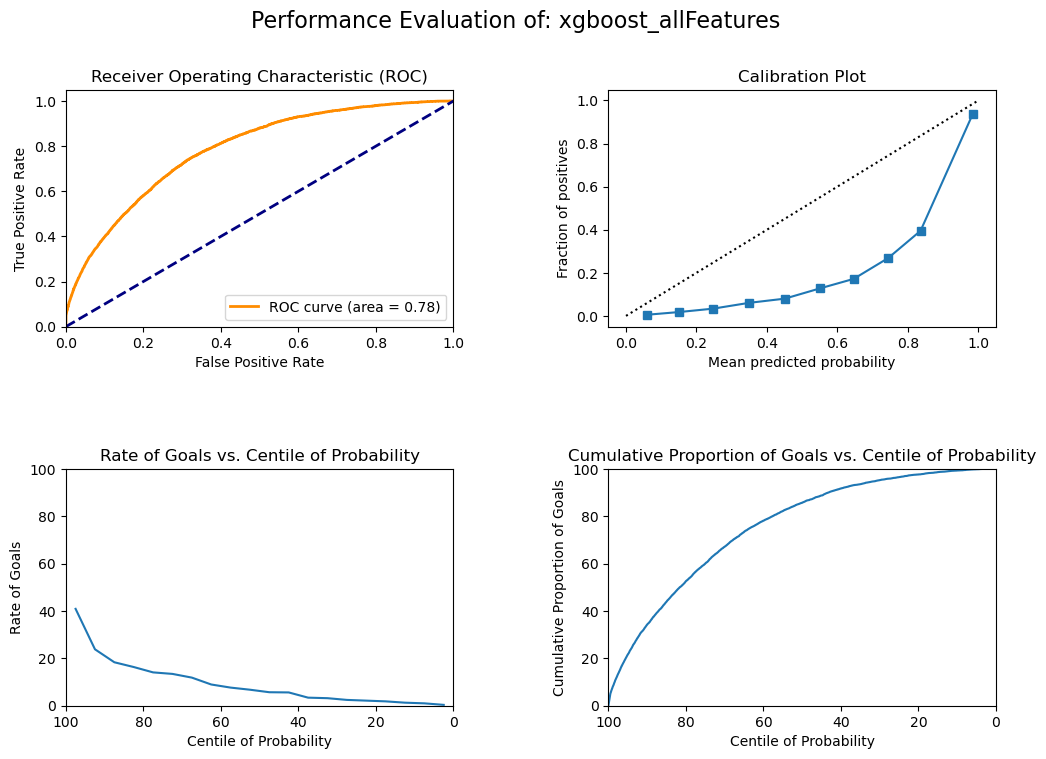

In [24]:
plots(y_valid,probs,"xgboost_allFeatures")

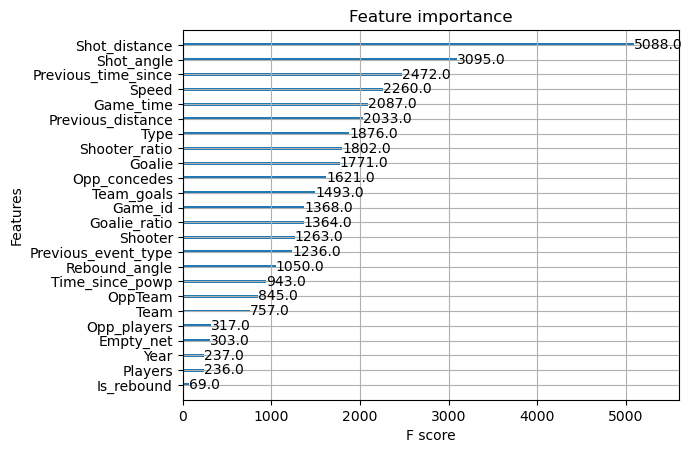

In [25]:
ax = plot_importance(xgb_allfeatures)
ax.figure.savefig('xgb_clf.png')

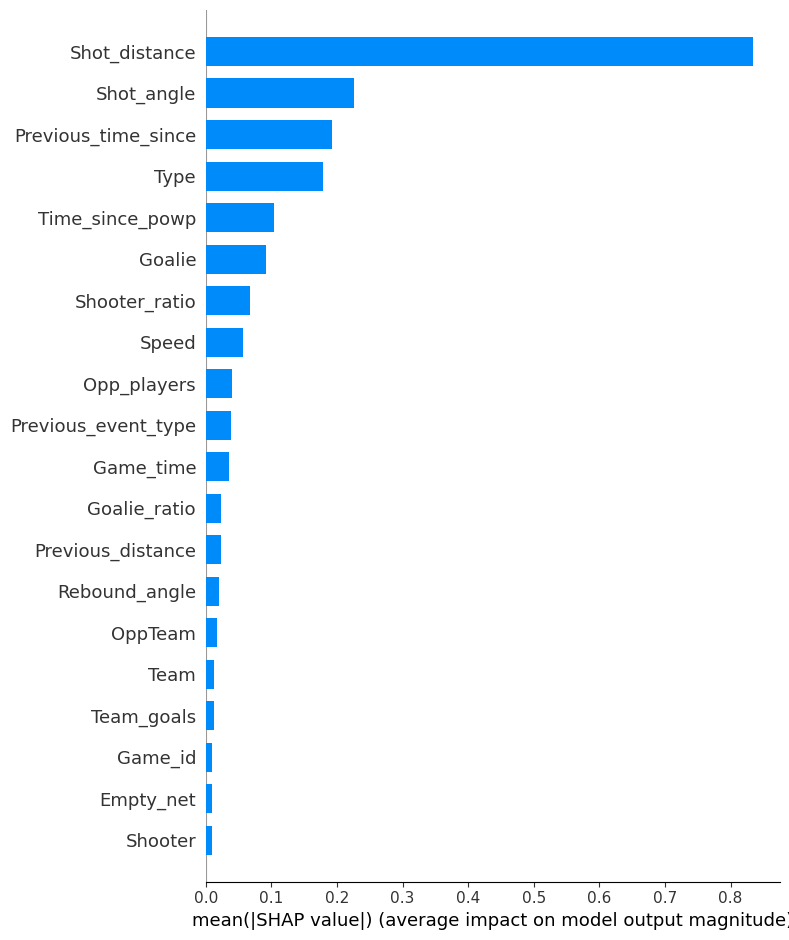

In [26]:
explainer = shap.Explainer(xgb_allfeatures)
shap_values = explainer(x_valid)
# Summary Plot (bar)
shap.summary_plot(shap_values,x_valid, plot_type="bar")

# Afficher le plot
plt.show()

In [27]:
X_trainXG_SHAP_=X_train[['Shot_distance','Shot_angle','Previous_time_since','Type','Speed','Time_since_powp','Game_time']]
X_valXG_SHAP=x_valid[['Shot_distance','Shot_angle','Previous_time_since','Type','Speed','Time_since_powp','Game_time']]

In [28]:
xgb_allfeatures = XGBClassifier(n_estimators=1570,max_depth=5,learning_rate=0.01,scale_pos_weight=9).fit(X_trainXG_SHAP_, y_train)

In [29]:
score_validation = xgb_allfeatures.score(X_valXG_SHAP, y_valid)

preds_val_selection = xgb_allfeatures.predict(X_valXG_SHAP)
# Calculer et afficher le score ROC AUC
score_roc_auc = roc_auc_score(y_valid, preds_val_selection)
print("ROC AUC : ", score_roc_auc)
precision = precision_score(y_valid, preds_val_selection)
print("precision : ", precision)

recall = recall_score(y_valid, preds_val_selection)
print("recall : ", recall)

ROC AUC :  0.6999163835316704
precision :  0.18837031369548585
recall :  0.7268969589607323


In [30]:
accuracy_distance = accuracy_score(y_valid, preds_val_selection)
accuracy_distance

0.6780380223891014

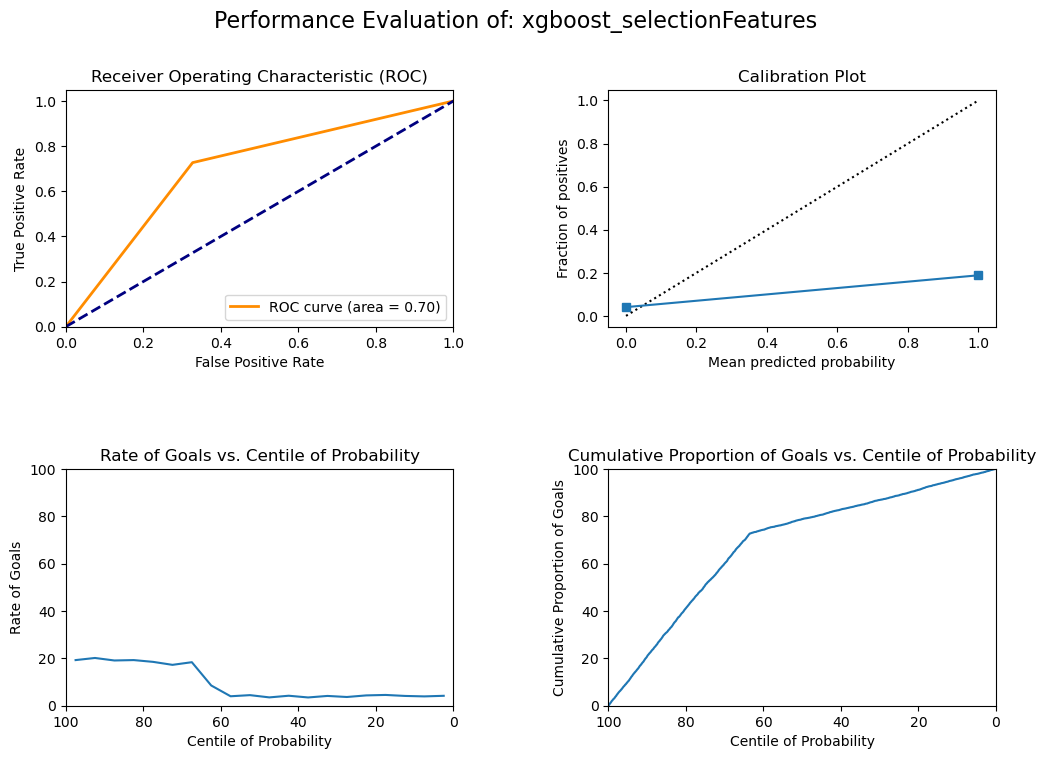

In [31]:
plots(y_valid,preds_val_selection,"xgboost_selectionFeatures")

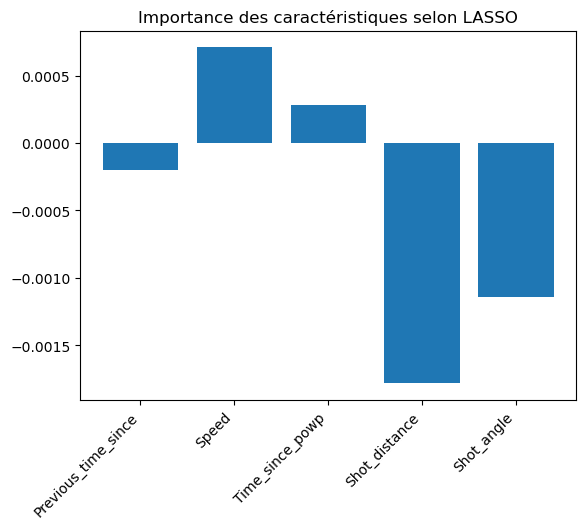

In [32]:
from sklearn import linear_model
from sklearn import feature_selection 

clf = linear_model.Lasso(alpha=0.1)
selector = feature_selection.SelectFromModel(estimator=clf,threshold="mean").fit(X_train,y_train)
selected_feature_indices = np.where(selector._get_support_mask())[0] 
res_list = [X_train.columns[i] for i in selected_feature_indices] 
res_list

### QUESTION1

In [ ]:
X_train_q1 = X_train[['Shot_distance', 'Shot_angle']]
X_val_q1 = x_valid[['Shot_distance', 'Shot_angle']]

In [ ]:
xgb_q1= XGBClassifier().fit(X_train_q1, y_train)

In [ ]:
# Calcul des scores d'entraînement et de validation
score_entrainement = xgb_q1.score(X_train_q1, y_train)
score_validation = xgb_q1.score(X_val_q1, y_valid)

# Prédiction sur l'ensemble de validation
predictions_validation = xgb_q1.predict(X_val_q1)
# Calculate and print the accuracy
accuracy_distance = accuracy_score(y_valid, predictions_validation)
print(f'Accuracy with distance feature: {accuracy_distance}')


Accuracy with distance feature: 0.9055581921219397


In [ ]:
y_prob_distance = xgb_q1.predict_proba(X_val_q1)[:, 1]

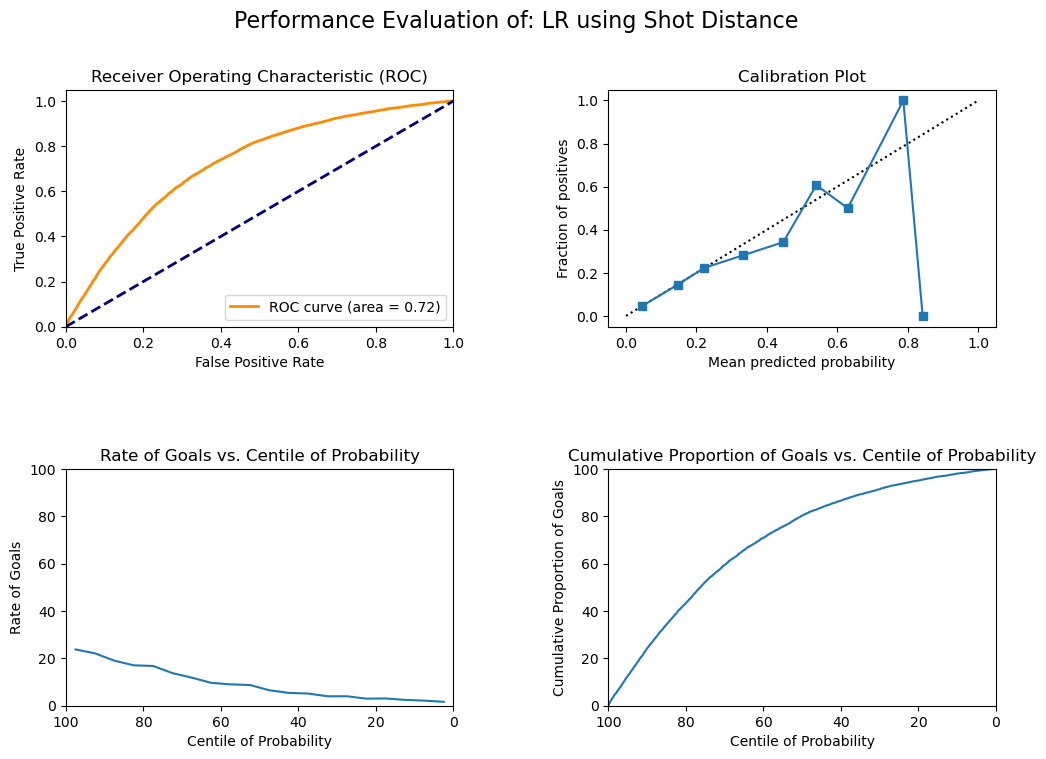

In [ ]:
from src.visualizations import plots
plots(y_valid,y_prob_distance,"LR using Shot Distance")